## BC2407 Project 

---

## <a id='content'>Table of Contents </a>
...

**Models (from proposal)**
- Association rules
- Quantile Regression
- MARS
- Random Forest 
- NN

...

**Business problem breakdown**:

#### 1. Bundle service provision - to help increase sales revenue 
    - Association rules 
    
    
#### 2. Customer Churn prediction (Categorical Y)
    - Logistic Regression 
    - Random Forest 
    - XG Boost 
    - NN
    *Selecting the best model*
    
    
#### 3. Business Insights - what are the more important ones?
    - a. Customer importance - Predicting CLTV (Continuous Y)
        - LR
        - Quantile Regression (remove) 
        - MARS
        - NN
        *Selecting the best model*
    - b. Feature importance 

...

**Our solution: basically to develop a data tool to help the company monitor customer churn better and gain more revenue**

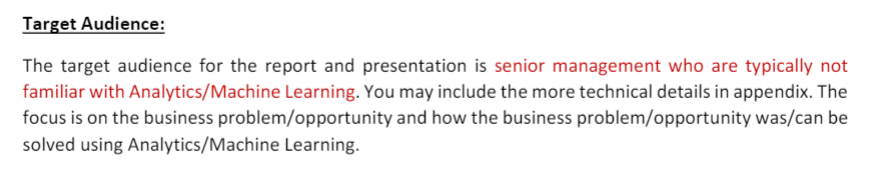

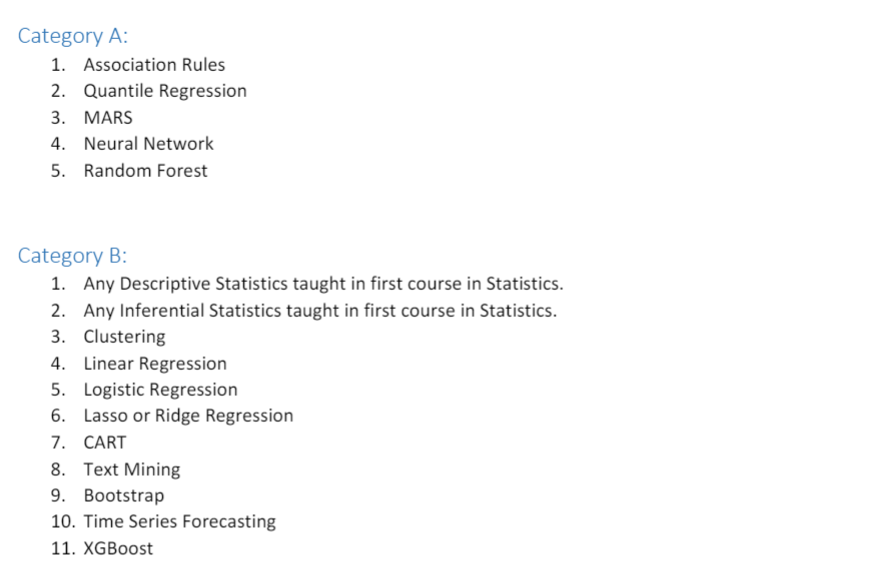

---

## 1. Data Preparation

**some useful info**

- **CLTV**: Customer Lifetime Value. 
    - A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
    
- **Churn Score**: 
    - A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
    
- **Churn Value**: 
    - 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

- **Referred a Friend**:
    - Indicates if the customer has ever referred a friend or family member to this company
    
- **Tenure in Months**:
    - Indicates the total amount of months that the customer has been with the company by the end of the quarter specified
    
- **Offer**:
    - Identifies the last marketing offer that the customer accepted, if applicable
    
- **Monthly Charge**:
    - Indicates the customer’s current total monthly charge for all their services from the company
    
- **Total Regular Charge**
    - Indicates the customer’s total regular charges, excluding additional charges

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import clear_output

import folium
from folium.plugins import MarkerCluster
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap

import plotly.offline as py 
import plotly.graph_objects as go
import plotly.express as px
# py.init_notebook_mode(connected=True)

# from matplotlib import rc
# rc('text', usetex=True)

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

%matplotlib inline

In [2]:
path = "data/"

# Note: - deal with total charges NA later
# useless_col = ['customerID','Payment Method','DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies']
useless_col = ['customerID','TechSupport','DeviceProtection','gender','ChurnValue',"TotalCharges"]
data1 = pd.read_csv(path+"Telco-Customer-Churn.csv",index_col=0)
data2 = pd.read_csv(path+"telco_churn_data.csv",index_col=0)
data2.columns = data2.columns.str.replace(" ",'')
col_to_merge = data2.columns.difference(data1.columns)
data_combined = data1.join(data2[col_to_merge])
data_combined = data_combined.reset_index().drop(useless_col,axis=1)
# data_combined.head()

In [3]:
# Check for NA values
for col in data_combined.columns:
    na_count = data_combined[col].isna().sum()
    if na_count>0:
        print(col, 'has',na_count,'missing values')

# Clean missing values 
data_combined = data_combined.drop(['ChurnCategory', 'ChurnReason','CustomerSatisfaction'], axis=1)
print("\nNumber of missing values in the cleaned dataset now: ",data_combined.isna().sum().sum())


ChurnCategory has 5174 missing values
ChurnReason has 5174 missing values
CustomerSatisfaction has 5209 missing values

Number of missing values in the cleaned dataset now:  0


In [4]:
data_combined = data_combined.replace("Yes", 1).replace("No", 0)
data_combined = data_combined.replace("Male", 1).replace("Female", 0)
data_combined['InternetService'] = data_combined['InternetService'].replace('DSL',1)
data_combined['InternetService'] = data_combined['InternetService'].replace('Fiber optic',1)
data_combined['InternetType'] = data_combined['InternetType'].replace('None','NA')

In [5]:
# data_combined[data_combined['Internet Service']==0]

In [6]:
# data_combined[data_combined['Phone Service']==0]

#### Generating useful variables

In [7]:
geographical_col = ['Latitude','ZipCode','Longitude','City']
data_filtered = data_combined.copy()
data_filtered = data_filtered.drop(geographical_col,axis=1)

In [8]:
def get_data_info(data_df:pd.DataFrame, data_filtered:pd.DataFrame=None):
    data_col = data_df.columns.tolist()
    data_info = pd.DataFrame(index=data_df.columns,columns=['dtype','unique_ct','eg1','eg2'])
    for col in data_col:
        data_info.loc[col,'dtype'] = data_df[col].dtype
        data_info.loc[col,'unique_ct'] = len(data_df[col].unique())
        data_info.loc[col,'eg1'] = data_df[col][0]
        data_info.loc[col,'eg2'] = data_df[col][1]
    data_info=data_info.sort_values('unique_ct',ascending=False)
    return data_info

In [9]:
data_info = get_data_info(data_filtered)

cat_col_binary_orig = data_info[data_info['unique_ct']<=2].index.tolist()
cat_col_multi = data_info[(data_info['unique_ct']<=6)&(data_info['unique_ct']>2)].index.tolist()
continuous_col = data_info[data_info['unique_ct']>6].index.tolist()

cat_col_binary_exceptions = []
for col in cat_col_multi.copy():
    print('\nChecking Value for: ', col)
    unique_val = data_combined[col].unique().tolist()
    print(unique_val)
    if 'No internet service' in unique_val or('No phone service' in unique_val):
        cat_col_multi.remove(col)
        cat_col_binary_exceptions.append(col)
        
cat_col_binary = cat_col_binary_orig+cat_col_binary_exceptions

print("\n\033[1mBinary Categorical Columns are: \033[0m\n",cat_col_binary)
# print("\n\033[1mBinary Categorical Columns (with exceptions) are: \033[0m\n",cat_col_binary_exceptions)
print("\n\033[1mMulti Categorical Columns are:\033[0m \n",cat_col_multi)
print("\n\033[1mContinuous Columns are:\033[0m \n",continuous_col)


Checking Value for:  Offer
['Offer E', 'None', 'Offer D', 'Offer C', 'Offer B', 'Offer A']

Checking Value for:  InternetType
['Fiber Optic', 'DSL', 'Cable', 'NA']

Checking Value for:  PaymentMethod
['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

Checking Value for:  Contract
['Month-to-month', 'One year', 'Two year']

Checking Value for:  StreamingMovies
[0, 1, 'No internet service']

Checking Value for:  StreamingTV
[0, 1, 'No internet service']

Checking Value for:  OnlineBackup
[1, 0, 'No internet service']

Checking Value for:  OnlineSecurity
[0, 1, 'No internet service']

Checking Value for:  MultipleLines
['No phone service', 0, 1]

Binary Categorical Columns are: 
 ['SeniorCitizen', 'StreamingMusic', 'Under30', 'ReferredaFriend', 'DeviceProtectionPlan', 'PremiumTechSupport', 'Married', 'Gender', 'Partner', 'Churn', 'PaperlessBilling', 'InternetService', 'PhoneService', 'Dependents', 'UnlimitedData', 'StreamingMovies', 'StreamingTV

In [10]:
# data_combined["TotalCharges"] = data_combined["TotalCharges"].astype("float")
data_combined[cat_col_binary+cat_col_multi] = data_combined[cat_col_binary+cat_col_multi].astype('category')
# get_data_info(data_combined)

In [11]:
# Encoding categorical Variables 
encoded_cols=[]
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    encoded_cols.extend(dummies.columns.tolist())
    res = res.drop([feature_to_encode], axis=1) 
    return(res)

    
data_encoded = data_combined.copy()
for col in cat_col_multi:
    print("Encoding variable" ,col)
    data_encoded = encode_and_bind(data_encoded,col)
encoded_cols=list(set(encoded_cols))
print("\nEncoded columns: ",encoded_cols)

# data_encoded.head()

Encoding variable Offer
Encoding variable InternetType
Encoding variable PaymentMethod
Encoding variable Contract

Encoded columns:  ['PaymentMethod_Bank transfer (automatic)', 'Offer_None', 'Offer_Offer E', 'Offer_Offer A', 'InternetType_Cable', 'Offer_Offer D', 'Contract_Two year', 'InternetType_NA', 'PaymentMethod_Electronic check', 'PaymentMethod_Credit card (automatic)', 'InternetType_Fiber Optic', 'PaymentMethod_Mailed check', 'Offer_Offer B', 'Contract_One year', 'InternetType_DSL', 'Offer_Offer C', 'Contract_Month-to-month']


In [12]:
data_combined.to_csv("data_combined.csv")

---

## 2. Data Exploration 

In [14]:
######################################################

### PLACEHOLDER ###

## e.g distribution, proportion, skewness, correlations etc 

######################################################

In [15]:
def PlotLocations(data):
    data['Latitude'] = data['Latitude'].astype(float)
    data['Longitude'] = data['Longitude'].astype(float)
    m_3 = folium.Map(location=[33.964131,-118.272783], tiles='cartodbpositron', zoom_start=13)

    mc = MarkerCluster()
    for idx, row in data.iterrows():
        if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
            mc.add_child(Marker([row['Latitude'], row['Longitude']]))
    m_3.add_child(mc)
    
    data_churn = data[data['Churn'] == '0']
    data_churn = data_churn[['Latitude', 'Longitude']]
    data_churn = data_churn.dropna(axis=0, subset=['Latitude','Longitude'])
    heat_data = [[row['Latitude'],row['Longitude']] for index, row in data_churn.iterrows()]

    HeatMap(heat_data).add_to(m_3)

    return m_3

PlotLocations(data_combined)

---

## 3. Models

### Association Rules

It is a rule-based machine learning technique used to find patterns (relationships, structures) in the data.

Association rules will help us determine the services customers often order in tandem. Baskets of services be formed based on the minimum confidence, support and lift that we specify. We will be using a dataset which contains the list of services purchased at supermarkets by different customers for this analysis.

**Business Problem**

Potentially to provide bundle promotion to increase sales

In [20]:
data_encoded.to_csv("data_encoded.csv")

In [16]:
phone_serivces = ['PhoneService','MultipleLines']
internet_services = ['InternetService','InternetType','UnlimitedData', 
                            'StreamingTV', 'StreamingMovies', 'StreamingMusic'
                             'OnlineSecurity','OnlineBackup',
                            'DeviceProtectionPlan','PremiumTechSupport']
other_services = ['PaperlessBilling','Contract']

internet_services_encoded=['InternetService','UnlimitedData', 'InternetType_NA',
                            'InternetType_DSL', 'InternetType_Cable', 'InternetType_Fiber Optic',
                            'StreamingTV', 'StreamingMovies', 'StreamingMusic',
                             'OnlineSecurity','OnlineBackup',
                            'DeviceProtectionPlan','PremiumTechSupport']

other_services_encoded=['PaperlessBilling',
                       'Contract_Two year','Contract_One year','Contract_Month-to-month']

# omitted variables: Offer, PaymentMethod
# multicat = ['Offer', 'PaymentMethod', 'InternetType', 'Contract']

all_services = phone_serivces+internet_services+other_services
all_services_encoded = phone_serivces+internet_services_encoded+other_services_encoded

In [17]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

min_sup=0.4
min_thres=0.4

print("Settings: ")
print("min_support: ", min_sup)
print("min_thres: ", min_thres)

Settings: 
min_support:  0.4
min_thres:  0.4


In [18]:
# Assoc Rule for all services
assoc_rule_data_all = data_encoded[all_services_encoded]
assoc_rule_data_all = assoc_rule_data_all.replace('No internet service',0)
assoc_rule_data_all = assoc_rule_data_all.replace('No phone service',0)
item_all = apriori(assoc_rule_data_all, use_colnames=True, min_support=min_sup)
assoc_rule_all = association_rules(item_all, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for Internet service
assoc_rule_data_internet = data_encoded[data_encoded['InternetService']==1][internet_services_encoded]
assoc_rule_data_internet = assoc_rule_data_internet.drop('InternetType_NA',axis=1)
item_internet = apriori(assoc_rule_data_internet, use_colnames=True, min_support=min_sup)
assoc_rule_internet = association_rules(item_internet, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for Internet service + others (paperless billing & contract)
assoc_rule_data_internet_others = data_encoded[data_encoded['InternetService']==1][internet_services_encoded+other_services_encoded]
assoc_rule_data_internet_others = assoc_rule_data_internet_others.drop('InternetType_NA',axis=1)
item_internet_others = apriori(assoc_rule_data_internet_others, use_colnames=True, min_support=min_sup)
assoc_rule_internet_others = association_rules(item_internet_others, metric = 'confidence', min_threshold=min_thres)

# Assoc Rule for phone service + others (paperless billing & contract)
assoc_rule_data_phone_others = data_encoded[data_encoded['PhoneService']==1][phone_serivces+other_services_encoded]
item_phone_others = apriori(assoc_rule_data_phone_others, use_colnames=True, min_support=min_sup)
assoc_rule_phone_others = association_rules(item_phone_others, metric = 'confidence', min_threshold=min_thres)

In [19]:
## Results DF Analysis - based on lift 
assoc_rule_all = assoc_rule_all.sort_values("lift",ascending=False)
assoc_rule_internet  = assoc_rule_internet .sort_values("lift",ascending=False)
assoc_rule_internet_others  = assoc_rule_internet_others .sort_values("lift",ascending=False)
assoc_rule_phone_others  = assoc_rule_phone_others .sort_values("lift",ascending=False)

---

## Predict Churn - Models


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

LR_model = LogisticRegression()
CART_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()
XGB_model = GradientBoostingClassifier()

In [21]:
# Utils functions 
from sklearn.metrics import confusion_matrix

def plot_cm(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    
    model_name="",
    
    linewidths=.5,
    cmap="YlGnBu",
    
    enable_print=False
):
    cm_train = confusion_matrix( y_train,y_train_pred)
    cm_test = confusion_matrix( y_test,y_test_pred)
    accuracy_train = (cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))
    accuracy_test = (cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))
   
    if enable_print:
        print("Train set accuracy (in%):", "{:.2f}%".format(accuracy_train*100))
        print("Test set accuracy (in%):", "{:.2f}%".format(accuracy_test*100))
        print()
    
    group_names = ['TN','FP','FN','TP']
    group_perc_train = ["{0:.2%}".format(value) for value in
                                    cm_train.flatten()/np.sum(cm_train)]
    group_perc_test = ["{0:.2%}".format(value) for value in
                                    cm_test.flatten()/np.sum(cm_test)]
    labels_train = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_perc_train)]
    labels_test = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_perc_test)]
    labels_train = np.asarray(labels_train).reshape(2,2)
    labels_test = np.asarray(labels_test).reshape(2,2)
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))

    sns.heatmap(cm_train, ax=ax1,fmt='',
                            annot=labels_train,linewidths=linewidths,cmap=cmap)
    ax1.set_xlabel('Predicted "Churn" status')
    ax1.set_ylabel('Actual "Churn" status') 
    ax1.set_title(model_name+'Confusion Matrix (Train)\n\n Accuracy: ' + "{:.2f}%".format(accuracy_train*100) + "\n") 
    ax1.xaxis.set_ticklabels(['0', '1'])
    ax1.yaxis.set_ticklabels(['0', '1'])

    sns.heatmap(cm_test, ax=ax2,fmt='',
                           annot=labels_test,linewidths=linewidths,cmap=cmap);
    ax2.set_xlabel('Predicted "Churn" status')
    ax2.set_ylabel('Actual "Churn" status')
    ax2.set_title(model_name+'Confusion Matrix (Test)\n\n Accuracy: ' + "{:.2f}%".format(accuracy_test*100) + "\n")
    ax2.xaxis.set_ticklabels(['0', '1'])
    ax2.yaxis.set_ticklabels(['0', '1'])
    
def get_cm_accuracy(
        y_train,
        y_train_pred,
        y_test,
        y_test_pred,
):
        cm_train = confusion_matrix( y_train,y_train_pred)
        cm_test = confusion_matrix( y_test,y_test_pred)
        accuracy_train = (cm_train[0,0]+cm_train[1,1])/sum(sum(cm_train))
        accuracy_test = (cm_test[0,0]+cm_test[1,1])/sum(sum(cm_test))
        
        return accuracy_train,accuracy_test
    
def plot_barh(
    data:pd.DataFrame,
    column_to_plot:str,
    title="",
    figsize=(8,3),
    title_size=18,
    label_size=14,
    style="bmh"
):
    plt.style.use(style)
    data_plot = data.copy()
    data_plot = data_plot.sort_values(column_to_plot,ascending=True)
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(data_plot.index,data_plot[column_to_plot])
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.set_title(title, size=title_size)
    
from sklearn.metrics import mean_squared_error,r2_score

def get_rmse(
        y_train,
        y_train_pred,
        y_test,
        y_test_pred,
):
    train_rmse = mean_squared_error(y_train,y_train_pred)**0.5
    test_rmse = mean_squared_error(y_test,y_test_pred)**0.5
    
    train_r2 = r2_score(y_train,y_train_pred)
    test_r2 = r2_score(y_test,y_test_pred)
    print("Train set rmse:", "{:.0f}".format(train_rmse))
    print("Test set rmse:", "{:.0f}".format( test_rmse ))
    print("Train set r2:", "{:.2f}".format(train_r2))
    print("Test set r2:", "{:.2f}".format( test_r2 ))
    return train_rmse,test_rmse,train_r2, test_r2

from sklearn.metrics import accuracy_score, fbeta_score,precision_score,recall_score,roc_auc_score,f1_score

def get_performance_metrics(
        y_test,
        y_test_pred,
):
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recallscore = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1score = f1_score(y_test, y_test_pred) 
    
    performance_df = pd.DataFrame({
        "Accuracy Score" : [accuracy],
        "Precision Score" : [precision],
        "Recall Score"    : [recallscore],
        "ROC-AUC Score": [roc_auc],
        "F1 Score"        : [f1score],
    })
    
    return performance_df

def plot_results(results_df, height=350):
    def output_tracer(metric,color) :
        tracer = go.Bar(y = model_results['Model'],
                        x = model_results[metric],
                        orientation = "h",name = metric ,
                        marker = dict(line = dict(width =.7),
                                      color = color)
                       )
        return tracer

    layout = go.Layout(dict(title = "Model performances",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "metric",
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,ticklen=5,gridwidth=1),
                            margin = dict(l = 120,t=60,b=50),
                            height = height
                           )
                      )

    trace1  = output_tracer("Accuracy Score","#6699FF")
    trace2  = output_tracer('Precision Score',"red")
    trace3  = output_tracer('Recall Score',"#33CC99")
    trace4  = output_tracer('ROC-AUC Score',"lightgrey")
    trace5  = output_tracer('F1 Score',"#FFCC99")

    data = [trace1,trace2,trace3,trace4,trace5]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

#### Run Models - default settings

In [22]:
# Prepare Data 
data_model = data_encoded.copy()
data_model = data_model.drop(geographical_col,axis=1)
data_model = data_model.replace("No internet service",0)
data_model = data_model.replace("No phone service",0)

dependent_var = ['Churn','CLTV']
independent_var = data_model.columns.tolist()
independent_var.remove('Churn')
independent_var.remove('CLTV')

# Useful Variables
model_list = ["Logistic Regression", "CART","Random Forest","XGBoost"]
performance_metrics = [ 'Model',"model_type","data_category","Accuracy Score","Precision Score","Recall Score","ROC-AUC Score","F1 Score"]

MODEL_MAP = {
    "Logistic Regression":LR_model, 
    "CART":CART_model,
    "Random Forest":RF_model,
    "XGBoost":XGB_model
}

MODEL_PRED_TRAIN_MAP = {}
MODEL_PRED_TEST_MAP = {}

model_results = pd.DataFrame(columns=performance_metrics)

In [23]:
def run_models(
    model_name_list,
    model_X_train,
    model_y_train,
    model_X_test,
    model_y_test,
    model_results,
    model_type = "default",
    data_category = "all",
    col_name=""
):
    for model_name in model_name_list:
        model = MODEL_MAP[model_name]
        model.fit(model_X_train,model_y_train)
        model_pred_train = model.predict(model_X_train)
        model_pred_test = model.predict(model_X_test)
        
        dict_name = model_name+"_"+model_type+"_"+data_category

        MODEL_PRED_TRAIN_MAP[dict_name]=model_pred_train
        MODEL_PRED_TEST_MAP[dict_name]=model_pred_test

        performance = get_performance_metrics(model_y_test,MODEL_PRED_TEST_MAP[dict_name])
        performance_list = performance.values.tolist()[0]
        results = [model_name+col_name]+[model_type] + [data_category] + performance_list 
        
        row_no = len(model_results)
        model_results.loc[row_no] = np.nan
        model_results.loc[row_no] = results
        row_no+=1
    return model_results

In [24]:
model_X = data_model[independent_var]
model_y = data_model['Churn']
model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(model_X, model_y, train_size=0.8,
                                                                                                random_state=2022)
run_models(
    model_name_list=model_list ,
    model_X_train=model_X_train,
    model_y_train=model_y_train,
    model_X_test=model_X_test,
    model_y_test=model_y_test,
    model_results=model_results,
    model_type = "default",
    data_category = "all",
    col_name=""
)

C:\Users\Yakun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Model model_type data_category Accuracy Score  \
0  Logistic Regression    default           all          0.795   
1                 CART    default           all          0.855   
2        Random Forest    default           all          0.907   
3              XGBoost    default           all          0.928   

  Precision Score Recall Score ROC-AUC Score F1 Score  
0           0.637        0.489         0.696    0.553  
1           0.723        0.713         0.809    0.718  
2           0.896        0.727         0.849    0.802  
3           0.932        0.781         0.881    0.850

#### Model - with balanced data

In [27]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=[0, 1],random_state = 2022)

model_X = data_model[independent_var]
model_y = data_model['Churn']
model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(model_X, model_y, train_size=0.8,
                                                                                                random_state=2022)
model_X_train_bal, model_y_train_bal = sm.fit_resample(np.array(model_X_train), np.array(model_y_train.ravel()))

run_models(
    model_name_list=model_list ,
    model_X_train=model_X_train_bal,
    model_y_train=model_y_train_bal,
    model_X_test=model_X_test,
    model_y_test=model_y_test,
    model_results=model_results,
    model_type = "default",
    data_category = "balanced",
    col_name=" balanced_data"
)

model_results=model_results.sort_values("Accuracy Score",ascending=False)

C:\Users\Yakun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### Model - Results Visualization

<p style="color:firebrick;font-weight: bold"> From the model results, we see that XGBoost with normal data has the best performance</p>


In [36]:
model_results

Model model_type data_category Accuracy Score  \
3                            XGBoost    default           all          0.928   
7              XGBoost balanced_data    default      balanced          0.925   
2                      Random Forest    default           all          0.907   
6        Random Forest balanced_data    default      balanced          0.903   
1                               CART    default           all          0.855   
5                 CART balanced_data    default      balanced          0.835   
0                Logistic Regression    default           all          0.795   
4  Logistic Regression balanced_data    default      balanced          0.760   

  Precision Score Recall Score ROC-AUC Score F1 Score  
3           0.932        0.781         0.881    0.850  
7           0.885        0.817         0.890    0.849  
2           0.896        0.727         0.849    0.802  
6           0.854        0.754         0.855    0.801  
1           0.723        0.713         0.809    0.718  
5           0.675        0.702         0.792    0.688  
0           0.637        0.489         0.696    0.553  
4           0.525        0.803         0.774    0.635

In [37]:
plot_results(model_results,height=600)

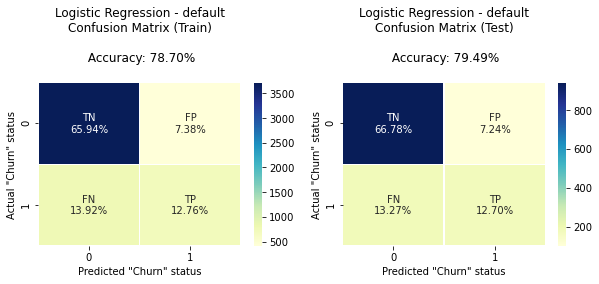

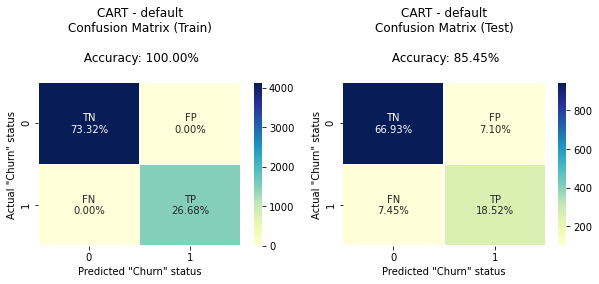

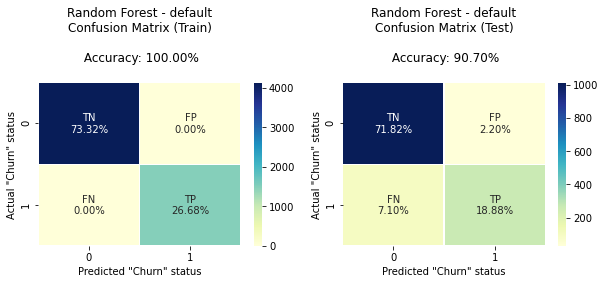

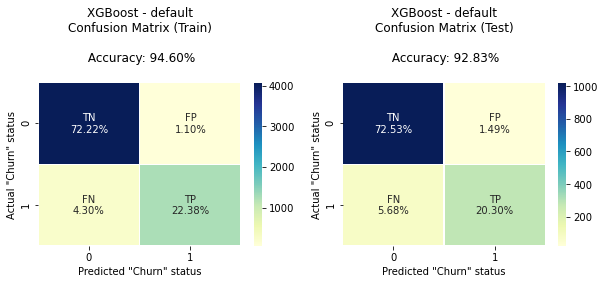

In [26]:
# Plot CM - default models
model_type="default"
data_category="all"
for model in model_list:
    dict_name = model+"_"+model_type+"_"+data_category
    y_train_pred = MODEL_PRED_TRAIN_MAP[dict_name]
    y_test_pred = MODEL_PRED_TEST_MAP[dict_name]
    
    plot_cm(model_y_train,
                    y_train_pred,
                    model_y_test,
                    y_test_pred,
                    model_name=model+" - default"+"\n",
                    linewidths=.5,
                    cmap="YlGnBu",
                    enable_print=False
                )

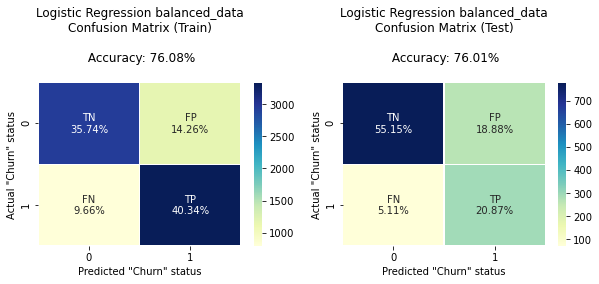

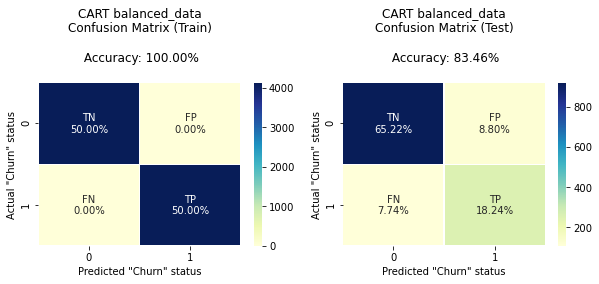

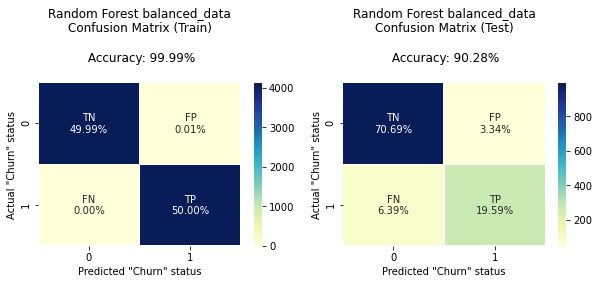

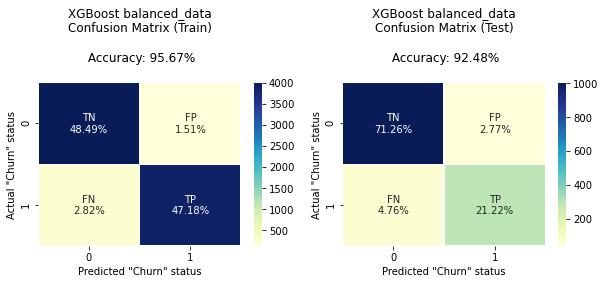

In [30]:
# Plot CM - models with balanced data 
model_type="default"
data_category="balanced"
for model in model_list:
    dict_name = model+"_"+model_type+"_"+data_category
    y_train_pred = MODEL_PRED_TRAIN_MAP[dict_name]
    y_test_pred = MODEL_PRED_TEST_MAP[dict_name]
    
    plot_cm(model_y_train_bal,
                    y_train_pred,
                    model_y_test,
                    y_test_pred,
                    model_name=model+" balanced_data"+"\n",
                    linewidths=.5,
                    cmap="YlGnBu",
                    enable_print=False
                )

#### Optimization - for XGBoost

---

### Linear Regression - CLTV

In [ ]:
from sklearn.linear_model import LinearRegression

data_LinR = data_encoded.copy()
data_LinR = data_LinR.drop(geographical_col,axis=1)
data_LinR = data_LinR.replace("No internet service",0)
data_LinR = data_LinR.replace("No phone service",0)

LinR_X = data_LinR[independent_var]
LinR_y = data_LinR['CLTV']
LinR_X_train, LinR_X_test, LinR_y_train, LinR_y_test = train_test_split(LinR_X, LinR_y, train_size=0.8,
                                                                                                random_state=2022)
LinR_model = LinearRegression()
LinR_model.fit(LinR_X_train, LinR_y_train)
LinR_pred_train = LinR_model.predict(LinR_X_train)
LinR_pred_test = LinR_model.predict(LinR_X_test)    

LinR_train_rmse,LinR_test_rmse,LinR_train_r2, LinR_test_r2 = get_rmse(LinR_y_train,LinR_pred_train,LinR_y_test,LinR_pred_test)

### MARS - CLTV

In [ ]:
# Have different error metrics 
from pyearth import Earth
data_MARS = data_encoded.copy()
data_MARS = data_MARS.drop(geographical_col,axis=1)
data_MARS = data_MARS.replace("No internet service",0)
data_MARS = data_MARS.replace("No phone service",0)

MARS_X = data_MARS[independent_var]
MARS_y = data_MARS['CLTV']
MARS_X_train, MARS_X_test, MARS_y_train, MARS_y_test = train_test_split(MARS_X, MARS_y, train_size=0.8,
                                                                                                random_state=2022)
MARS_model = Earth()
MARS_model.fit(MARS_X_train, MARS_y_train)
MARS_pred_train = MARS_model.predict(MARS_X_train)
MARS_pred_test = MARS_model.predict(MARS_X_test)    

MARS_train_rmse,MARS_test_rmse,MARS_train_r2, MARS_test_r2 = get_rmse(MARS_y_train,MARS_pred_train,MARS_y_test,MARS_pred_test)

### Neural Network - CLTV

In [ ]:
# Have different error metrics 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

data_NN2 = data_encoded.copy()
data_NN2 = data_NN2.drop(geographical_col,axis=1)
data_NN2 = data_NN2.replace("No internet service",0)
data_NN2 = data_NN2.replace("No phone service",0)

NN2_X = data_NN2[independent_var]
NN2_y = data_NN2['CLTV']
NN2_X_train, NN2_X_test, NN2_y_train, NN2_y_test = train_test_split(NN2_X, NN2_y, train_size=0.8,
                                                                                                random_state=2022)
# Normalization 
scaler = StandardScaler()
scaler.fit(NN_X_train)
NN_X_train = scaler.transform(NN_X_train)
NN_X_test = scaler.transform(NN_X_test)

NN2_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
NN2_model.fit(NN2_X_train, NN2_y_train)
NN2_pred_train = NN2_model.predict(NN2_X_train)
NN2_pred_test = NN2_model.predict(NN2_X_test)    

NN2_train_rmse,NN2_test_rmse,NN2_train_r2, NN2_test_r2 = get_rmse(NN2_y_train,NN2_pred_train,NN2_y_test,NN2_pred_test)

---

In [ ]:
# Accuracy Table 
models = ['Linear Regression ','MARS', 'Neural Network']
results_df = pd.DataFrame(index=models,columns=["train_accuracy","test_accuracy"])
results_df.loc['Linear Regression']=[LinR_train_r2,LinR_test_r2]
results_df.loc['MARS']=[MARS_train_r2,MARS_test_r2]
results_df.loc['Neural Network']=[NN2_train_r2,NN2_test_r2]

results_df = results_df.sort_values(by='test_accuracy',ascending=False)
results_df

In [ ]:
plot_barh( results_df,
                column_to_plot = 'test_accuracy',
                title = "Model Accuracy - CLTV (testset)",
                figsize=(8,3),
                title_size=16,
                label_size=13,
                style="bmh"
         )